In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as m
import os
import datetime
import pandas as pd

In [2]:
path_raw = '//icnas4.cc.ic.ac.uk/rs5115/MSci Project/raw_spectra' #path with raw spectra files
path_logs = '//icnas4.cc.ic.ac.uk/rs5115/MSci Project/bruker_logs' #path with eventlog and temperatures

temperature_log = 'thursday2-20180927113645.log' #log of temperatures
event_log = 'EventLog_20180927112225.log' #event log

In [3]:
file_array = []     #empty array to append filenames in original order (wrong order)
all_the_files = np.array([i for i in os.listdir(path_raw) if os.path.isfile(os.path.join(path_raw,i)) and i.startswith('IC_raw_spectra_')]) #all files in directory starting with 'IC_raw_spectra'

for f in all_the_files:
    file_array.append(f.strip('IC_raw_spectra.tx'))      #stripping file names to get the number at the end

file_integers = sorted([int(i) for i in file_array])     #number converted to sorted integers (not naturally done)


all_files_list = []    #final file list, in order

for num in file_integers: #add integer to string to make files_list
    all_files_list.append('IC_raw_spectra_'+str(num)+'.txt')

In [4]:
"""removing files without associated temperature measurement"""

def read_temperatures_check(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list
    temp1 = [float(b) for b in (lines[1].split())[6:]]
    tempHBB1 = temp1[0]

    return tempHBB1

In [5]:
delete_files = [] #files where there is no temperature measurement

for f in all_files_list:
    if read_temperatures_check(path_raw, f) == 0.0:
        delete_files.append(f)

files_list = [x for x in all_files_list if x not in delete_files]

In [6]:
"""retrieving times from files"""

def read_times(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list
    
    times = lines[0].split() #retrieve times of beginning of all spectra in a file
    return times

In [7]:
all_times_list = [] #final time list [374x4] (in HH:MM:SS.microsec format)

for f in range(len(files_list)): #go through files_list and extract times
    all_times_list.append(read_times(path_raw, files_list[f]))

flat_list = [item for sublist in all_times_list for item in sublist] #1D list of all times (in HH:MM:SS.microsec format)


spectrum_times = [] #final time list [(374*4)x1] in seconds from midnight format

for i in flat_list: #convert times to seconds format
    time = datetime.datetime.strptime(i, '%H:%M:%S.%f')
    spectrum_times.append((time.microsecond)/1000000 +time.second+time.minute*60+time.hour*3600)

In [8]:
time_col_name = 'Time'

In [9]:
# Read the log file - extract log_times and log_h_or_c
log_file = open(os.path.join(path_logs, event_log)).readlines()

log_file_list = []
for i in log_file[9:-3]:
    log_file_list.append(i.split(' '))
for i in log_file_list:
    i.pop(5)
    i.pop(4)
    i.pop(3)
    i.pop(0)
# each item has length either 3 or 4. Length 4 is at start of h/c BB measurement

In [10]:
log_times = [] # all times in seconds since midnight
log_h_c = []

for i in log_file_list:
    time = datetime.datetime.strptime(i[0]+i[1], '%I:%M:%S%p')
    log_times.append(time.second+time.minute*60+time.hour*3600)
    if len(i) == 4:
        log_h_c.append(i[-1][0])
    elif len(i) == 3:
        log_h_c.append(log_h_c[-1])
    else:
        raise Exception('Error')

In [11]:
hc_log = pd.DataFrame(
    {time_col_name: log_times,
     'h/c': log_h_c,
    })
hc_log

,Time,h/c
0,44581,h
1,44583,h
2,44585,h
3,44588,h
4,44590,h
5,44592,h
6,44595,h
7,44597,h
8,44600,h
9,44602,h


In [12]:
def insert_row(i, df, line): # insert a row at a given index i and re-index all rows below it
    dfA = df.iloc[:i, ]
    dfB = df.iloc[i:, ]
    df = dfA.append(line, sort=False).append(dfB, sort=False).reset_index(drop = True)
    return df

times = spectrum_times
times.sort(reverse = True)
for t in times:
    i=0
    if t < log_times[0]:
        line = pd.DataFrame([t], columns = [time_col_name])
        hc_log = insert_row(i, hc_log, line)
    else:
        while hc_log.at[i, time_col_name] <= t:
            i += 1   
        line = pd.DataFrame([t], columns = [time_col_name])
        hc_log = insert_row(i, hc_log, line)

In [13]:
hc_list = []

for i in range(hc_log.shape[0]-1):
    value = hc_log.at[i, 'h/c']
    if value != 'c' and value != 'h':
        hc_list.append(hc_log.iloc[i+1]['h/c'])

In [14]:
times.sort()

print('times list length is: ' + str(len(times)))
print('h/c list length is: ' + str(len(hc_list)))
print('ratio of h/c to times is: ' + str(len(hc_list)/len(times)))

hc_and_times = pd.DataFrame(
    {'Spectrum': times,
     'hc': hc_list
    })

hc_and_times

times list length is: 1416
h/c list length is: 1416
ratio of h/c to times is: 1.0


,Spectrum,hc
0,45419.910,c
1,45433.383,c
2,45446.855,c
3,45460.268,c
4,45478.496,c
5,45491.910,c
6,45505.383,c
7,45518.795,c
8,45538.796,h
9,45552.269,h


In [15]:
# Read log temperature file
def read_log_file_temperature(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines()
    time = [(datetime.datetime.strptime(i[0:17], '%Y%m%d,%H:%M:%S')) for i in lines]
    time_sec = [time[i].second+time[i].minute*60+time[i].hour*3600 for i in range(len(time))]    
    temp_cold = [float((i[-6:-1])) for i in lines] # temperature of external black body
    temp_hot = [float((i[-12:-7])) for i in lines] # temperature of external black body
    return temp_hot, temp_cold, time, time_sec

In [16]:
temp_hot, temp_cold, time, temp_time = read_log_file_temperature(path_logs, temperature_log)

In [17]:
temp_log = pd.DataFrame(
    {time_col_name: temp_time,
     'hot': temp_hot,
     'cold': temp_cold
    })
temp_log

,Time,hot,cold
0,45405,64.83,22.38
1,45408,64.60,22.38
2,45410,64.61,22.39
3,45412,64.64,22.40
4,45414,64.66,22.40
5,45417,64.65,22.40
6,45419,64.68,22.41
7,45421,64.71,22.42
8,45423,64.74,22.41
9,45425,64.72,22.42


In [18]:
temps_avg = []
temps_std = []

i=0
for spectrum in times[:-1]:
    times_list = list(filter(lambda t: (t>spectrum and t<times[i+1]) , temp_time))
    index_list = [temp_time.index(item) for item in times_list]
    if hc_list[i] == 'h':
        temps_list = [temp_hot[a] for a in index_list]
    elif hc_list[i] == 'c':
        temps_list = [temp_cold[a] for a in index_list]
    temps_avg.append(np.average(temps_list))
    temps_std.append(np.std(temps_list))
    i+=1

In [19]:
final_frame = pd.DataFrame(
    {'Spectrum_(time_from_midnight)': times[:-1],
     'h_or_c': hc_list[:-1],
     'temp_avg': temps_avg,
     'temp_std': temps_std,
    })
final_frame

,Spectrum_(time_from_midnight),h_or_c,temp_avg,temp_std
0,45419.910,c,22.426667,1.105542e-02
1,45433.383,c,22.448333,6.871843e-03
2,45446.855,c,22.468571,8.329931e-03
3,45460.268,c,22.505556,1.065740e-02
4,45478.496,c,22.538333,1.213352e-02
5,45491.910,c,22.565714,1.049781e-02
6,45505.383,c,22.586667,4.714045e-03
7,45518.795,c,22.613333,9.428090e-03
8,45538.796,h,66.315714,7.027642e-02
9,45552.269,h,66.380000,3.109126e-02


In [20]:
temps_avg_4 = []
temps_std_4 = []

while len(times)%4 != 0:
    del times[-1]

times_4 = np.reshape(np.array(times), (int(np.floor(len(times)/4)),4))

i=0
for spectra in times_4[:-1]:
    times_list = list(filter(lambda t: (t>spectra[0] and t<times_4[i+1][0]) , temp_time))
    index_list = [temp_time.index(item) for item in times_list]
    if hc_list[i*4] == 'h':
        temps_list = [temp_hot[a] for a in index_list]
    elif hc_list[i*4] == 'c':
        temps_list = [temp_cold[a] for a in index_list]
    temps_avg_4.append(np.average(temps_list))
    temps_std_4.append(np.std(temps_list)) 
    i+=1

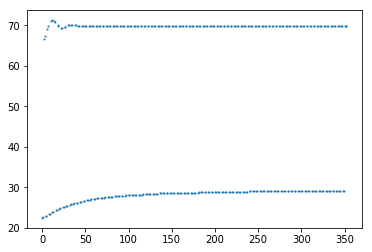

In [21]:
# check that there are no outliers
plt.scatter(np.arange(len(temps_avg_4)), temps_avg_4, s=1)
plt.show()

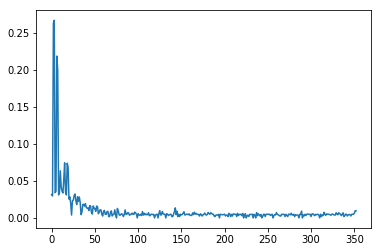

In [22]:
plt.plot(np.arange(len(temps_std_4)), temps_std_4)
plt.show()

In [23]:
hc_list_4 = hc_list[3::4]
spectra_times = [time[0] for time in times_4][:-1]

for a in hc_list_4[:-1]:
    if a != 'h' and a != 'c':
        b = hc_list_4[:-1].index(a)

final_frame_4 = pd.DataFrame(
    {'Spectrum_(time_from_midnight)': spectra_times,
     'temp_std': temps_std_4,
     'h_or_c': hc_list_4[:-1],
     'temp_avg': temps_avg_4
    })

final_frame_4 = final_frame_4.iloc[:b] #delete row with NaN in it

final_frame_4

,Spectrum_(time_from_midnight),temp_std,h_or_c,temp_avg
0,45419.910,0.031493,c,22.467143
1,45478.496,0.029699,c,22.579643
2,45538.796,0.262712,h,66.579643
3,45597.323,0.266833,h,67.300000
4,45656.645,0.034070,c,22.918519
5,45715.991,0.035990,c,23.041071
6,45774.887,0.218523,h,69.211071
7,45834.205,0.199075,h,69.823929
8,45894.485,0.031063,c,23.394074
9,45953.806,0.033995,c,23.501000


In [35]:
h = 6.626e-34
c = 3.0e+8
k = 1.381e-23

a = 2*h*(c**2)
e = h*c/k

def planck(wavenumber, T): # T in Celsius
    return 100*a*((wavenumber*100)**3)/(np.exp(e*(wavenumber*100)/T)-1)

22.579642857142858
0.02969874250069263


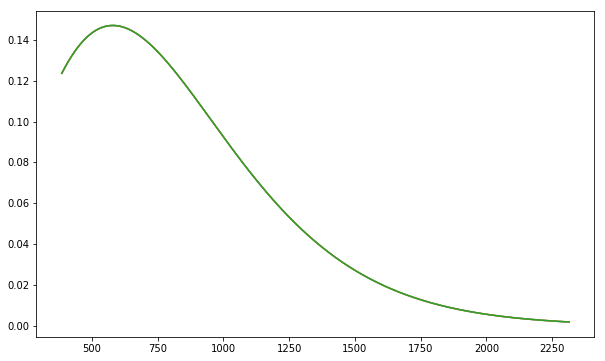

66.57964285714286
0.2627122562649807


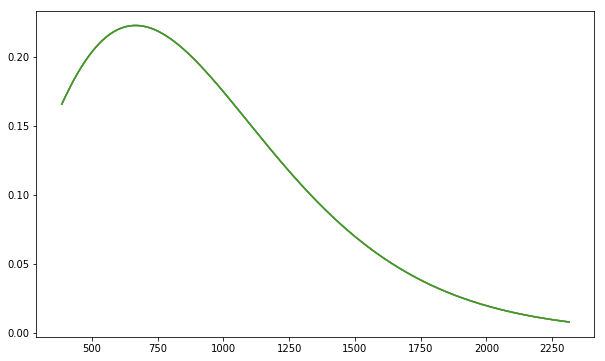

69.93275862068967
0.004469476343725493


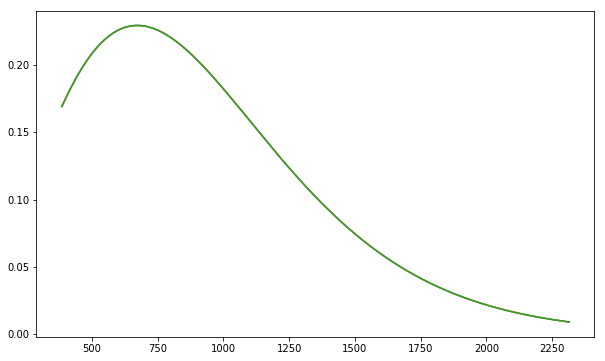

27.48392857142857
0.00488385511827665


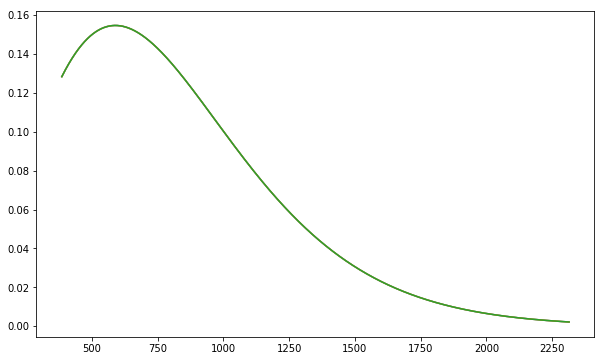

28.53931034482758
0.005206782369151959


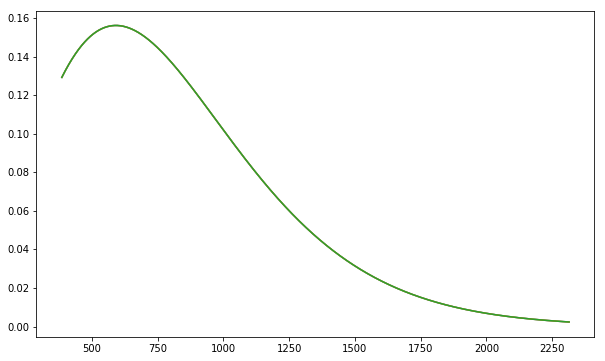

69.84185185185184
0.008622553130978193


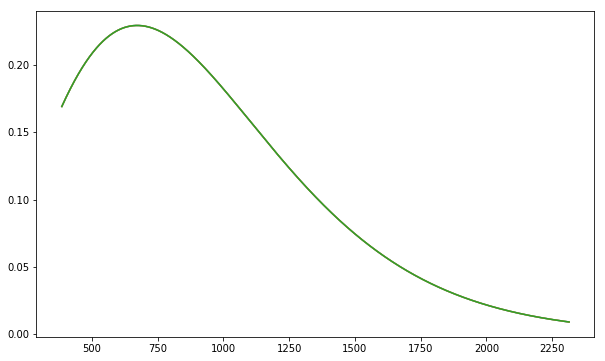

69.90586206896553
0.004925123054163004


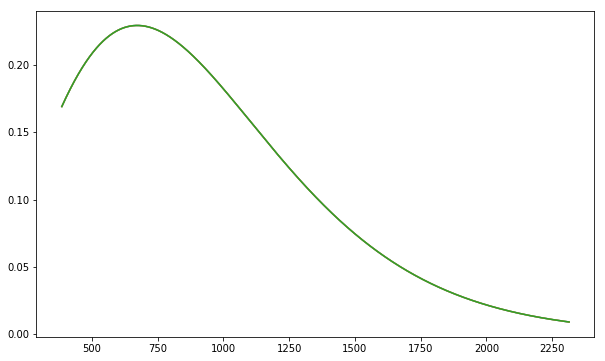

28.884285714285713
0.004948716593054709


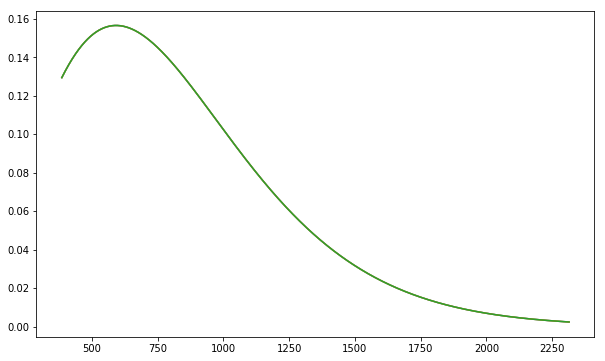

29.090344827586215
0.0018246560765965546


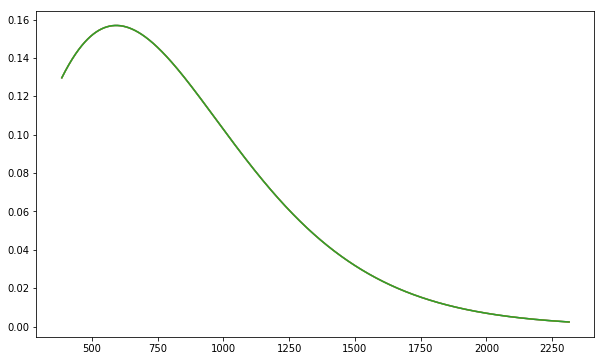

69.89071428571431
0.00371153744479235


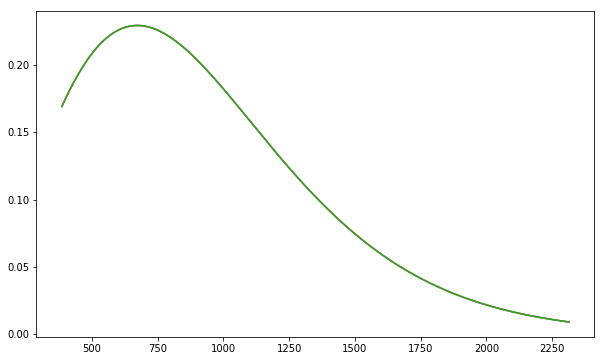

69.91620689655174
0.004852154234302581


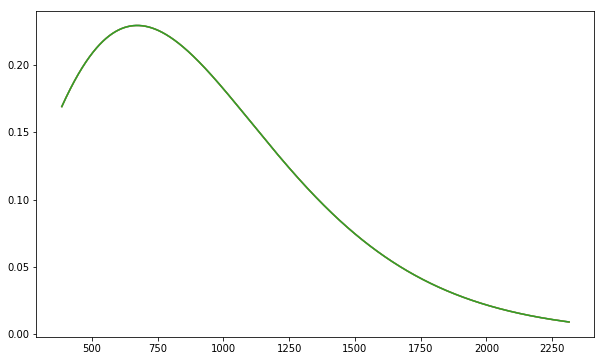

29.225000000000005
0.005000000000000782


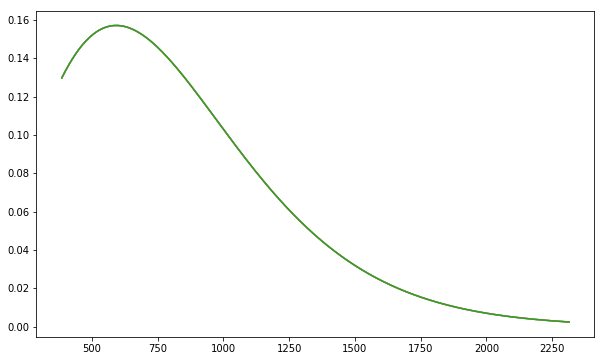

In [41]:
spectra_indeces = [1,2,71,72,141,142,211,212,281,283,347,348]
wavenums = raw_wavenumbers

for spectrum in spectra_indeces:
    temp_avg = final_frame_4.at[spectrum,'temp_avg'] #get it from the dataframe
    std = final_frame_4.at[spectrum,'temp_std']
    print(temp_avg)
    print(std)
    radiances_avg = []
    rad_minus = []
    rad_plus = []
    for wn in wavenums:
        radiances_avg.append(planck(wn, temp_avg+273.15))
        rad_minus.append(planck(wn, temp_avg+273.15-std))
        rad_plus.append(planck(wn, temp_avg+273.15+std))
    fig = plt.figure(figsize=(10,6)) 
    plt.plot(wavenums, radiances_avg)
    plt.plot(wavenums, radiances_avg)
    plt.plot(wavenums, radiances_avg)
    plt.show()

In [26]:
def read_wavenumbers(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list

    wns = []
    for i in lines[5:]:
        line = i.split()
        split_lines = [float(a) for a in line]
        wns.append(split_lines[0])

    return wns

raw_wavenumbers = read_wavenumbers(path_raw, files_list[0]) #all wavenumbers are the same in all files so just need to read from the first file

In [27]:
def read_all_raw_spectra(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list

    sp1 = []
    sp2 = []
    sp3 = []
    sp4 = []
    
    for i in lines[5:]:
        line = i.split()
        split_lines = [float(a) for a in line]
        sp1.append(split_lines[1])
        sp2.append(split_lines[2])
        sp3.append(split_lines[3])
        sp4.append(split_lines[4])
    
    avg_4_spec = 0.25*(np.array(sp1) + np.array(sp2) + np.array(sp3) + np.array(sp4))
    
    return avg_4_spec #list of raw value as function of wavenumber averaged over the 4 spectra

In [28]:
average_4_spectra = []   #a list with 352 elements, each of which is a list of 4 spectra, which is a list of 8000 points each
print(range(len(files_list)-2))
for f in range(len(files_list)-2):
    average_4_spectra.append(read_all_raw_spectra(path_raw, files_list[f]))

range(0, 352)


22.579642857142858
0.02969874250069263


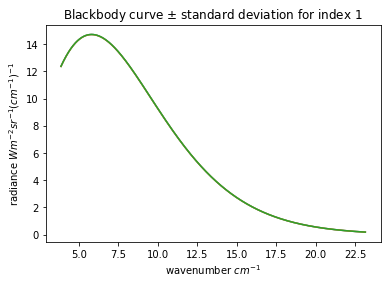

66.57964285714286
0.2627122562649807


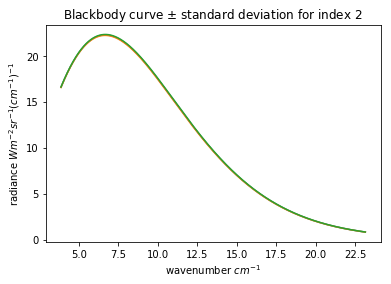

69.93275862068967
0.004469476343725493


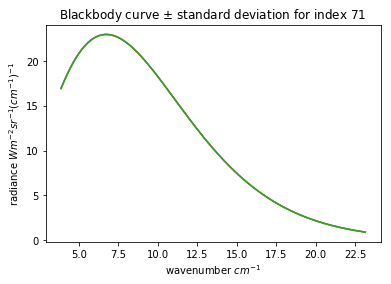

27.48392857142857
0.00488385511827665


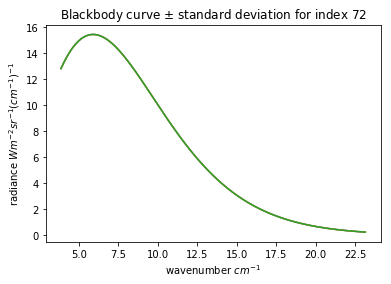

28.53931034482758
0.005206782369151959


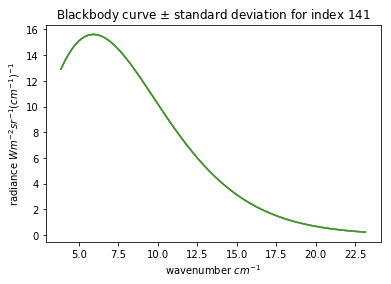

69.84185185185184
0.008622553130978193


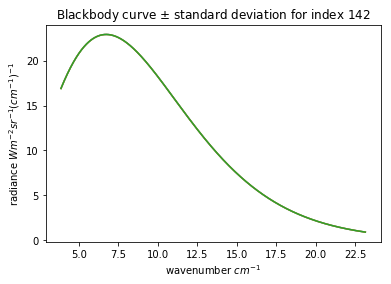

69.90586206896553
0.004925123054163004


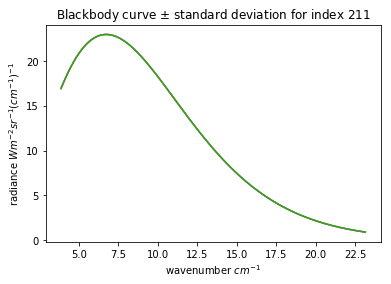

28.884285714285713
0.004948716593054709


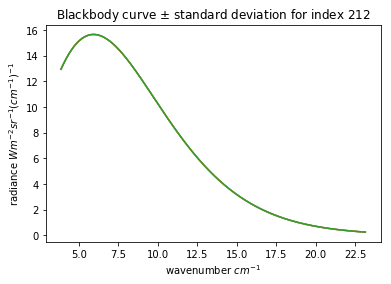

29.090344827586215
0.0018246560765965546


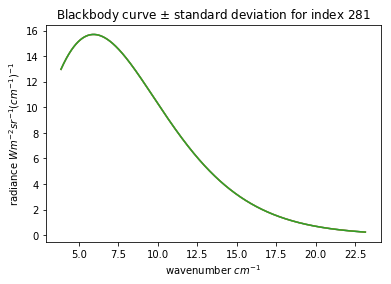

69.89071428571431
0.00371153744479235


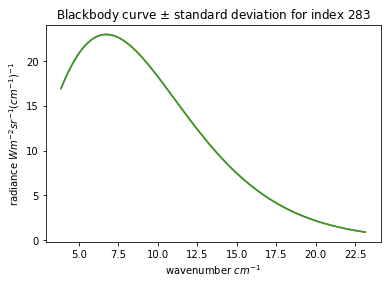

69.91620689655174
0.004852154234302581


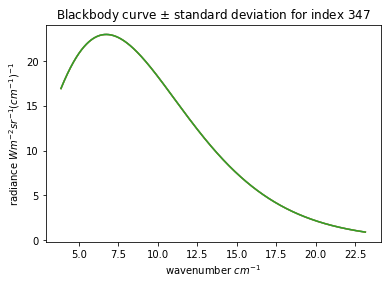

29.225000000000005
0.005000000000000782


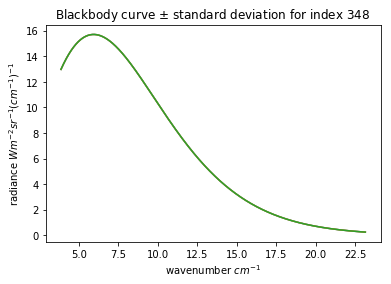

In [55]:
spectra_indices = [1,2,71,72,141,142,211,212,281,283,347,348]
wavenums = np.array(raw_wavenumbers)

for spectrum in spectra_indices:       #plot planck curve at some temperature
    temp_avg = final_frame_4.at[spectrum,'temp_avg']
    std = final_frame_4.at[spectrum, 'temp_std']
    print(temp_avg)
    print(std)
    radiances_avg = []
    rad_minus = []
    rad_plus = []
    
    for wn in wavenums:
        radiances_avg.append(planck(wn, temp_avg+273.15))
        rad_minus.append(planck(wn, temp_avg+273.15-std))
        rad_plus.append(planck(wn, temp_avg+273.15+std))

    fig = plt.figure()
    plt.plot([x/100 for x in wavenums], [r*100 for r in radiances_avg]) #might need to *100 once we have dataframe back
    plt.plot([x/100 for x in wavenums], [r*100 for r in rad_minus])
    plt.plot([x/100 for x in wavenums], [r*100 for r in rad_plus])

    plt.title('Blackbody curve $\pm$ standard deviation for index ' + str(spectrum))
    plt.xlabel('wavenumber $cm^{-1}$')
    plt.ylabel('radiance $W m^{-2} sr^{-1} (cm^{-1})^{-1}$')
    plt.show()

In [56]:
def response_fn(spectrum_number): 
    wavenums = np.array(raw_wavenumbers)
    
    (a,b) = (average_4_spectra[spectrum_number], average_4_spectra[spectrum_number + 1])
    if a[1000] < b[1000]:
        V_c = a
        V_h = b
    else:
        V_c = b
        V_h = a
    #print('V_c = {}'.format(V_c[1000]))
    #print('V_h = {}'.format(V_h[1000]))
    V_diff = np.array(V_h)-np.array(V_c)
    
    (e,f) = (final_frame_4.at[spectrum_number,'temp_avg'], final_frame_4.at[spectrum_number+1,'temp_avg'])
    if e<f:
        temp_average_c = e
        temp_average_h = f
    else:
        temp_average_c = f
        temp_average_h = e
        
    #std_dev_h = final_frame_4.at[spectrum_number, 'temp_std']
    #std_dev_c = final_frame_4.at[spectrum_number+1, 'temp_std']
    #print('temphot = {}'.format(temp_average_h))
    #print('tempcold = {}'.format(temp_average_c))
    
    radiances_avg_h = []
    radiances_avg_c = []
    #rad_minus_h = []
    #rad_plus_h = []
    
    for wn in wavenums:
        radiances_avg_h.append(planck(wn, temp_average_h+273.15))
        radiances_avg_c.append(planck(wn, temp_average_c+273.15))
        #rad_minus_h.append(planck(wn, temp_avg_h+273.15-std))
        #rad_plus_h.append(planck(wn, temp_avg_h+273.15+std))
    
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)
    
    def division(raw_val,planck_val):
        return raw_val/planck_val
    
    division_vec = np.vectorize(division)

    ratio = division_vec(V_diff, rad_diff)
    
    return(ratio)
'''    
    fig = plt.figure()
    plt.plot(wavenums, ratio)
    plt.xlabel('wavenumber $cm^{-1}$')
    plt.ylabel('response $(W m^{-2} sr^{-1} (cm^{-1})^{-1})^{-1}$ -- fix these units')
    plt.show()
'''

"    \n    fig = plt.figure()\n    plt.plot(wavenums, ratio)\n    plt.xlabel('wavenumber $cm^{-1}$')\n    plt.ylabel('response $(W m^{-2} sr^{-1} (cm^{-1})^{-1})^{-1}$ -- fix these units')\n    plt.show()\n"

In [58]:
all_resp_functions = []
indeces = np.arange(1, len(spectra_times)-2, 2)

for i in indeces:
    all_resp_functions.append(response_fn(i))

print(all_resp_functions)

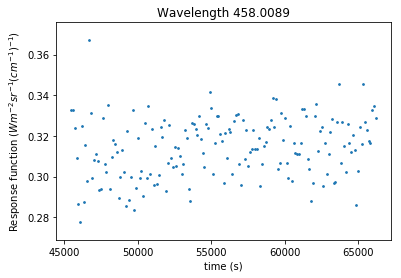

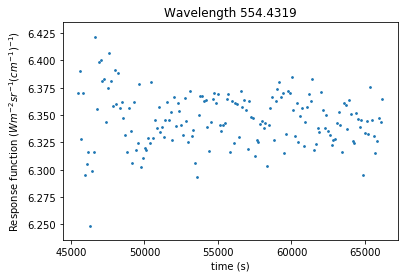

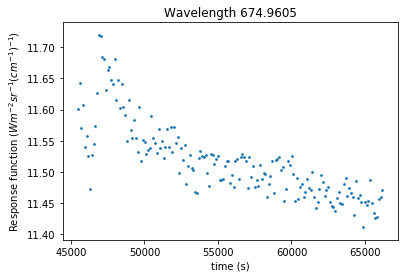

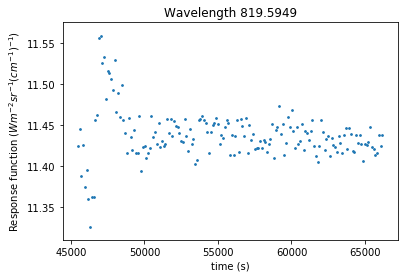

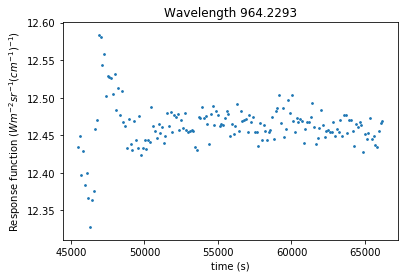

In [59]:
def plot_resp(n):
    plt.scatter(spectra_times[1:-2:2], [x[n] for x in all_resp_functions], s=3)
    plt.title('Wavelength {}'.format(raw_wavenumbers[n]))
    plt.xlabel('time (s)')
    plt.ylabel('Response function ($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
    plt.show()
plot_resp(150)
plot_resp(350) 
plot_resp(600)
plot_resp(900) 
plot_resp(1200)

resp_std = []

for t in range(len(spectra_times[1:-2:2])-1):
    responses= []
    for i in all_resp_functions:
        responses.append(i[t])
        resp_std.append(np.std(responses))

plt.scatter(spectra_times[1:-2:2], responses, s=3)
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()

In [33]:
#need to fix units on response function
# plot std of resp function as function of wavenumber